In [2]:
# Change current working directory (for cloud kernel only)
import os
os.chdir('proshantokumar/percolation-on-WPSL2-with-defects')

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random

In [4]:
# Store column numbers for easy remembering
x_left = 0
x_right = 1
y_bottom = 2
y_top = 3
x_len = 4
y_len = 5
area = 6
lneighbors = 0
rneighbors = 1
bneighbors = 2
tneighbors = 3
allneighbors = 4

In [69]:
# Create a function to generate a lattice using cpu
from typing import Tuple, List

def generate(time: int, discard_prob: float = 0) -> Tuple[np.ndarray, List[List[List[int]]]]: # type: ignore
    # Empty Block class instances before generating a new lattice
    # Since we will discard some blocks, we don't know the total number of blocks in advance.
    # This is the maximum number of blocks we can have in the lattice.
    total_num_of_blocks = 3*time + 1

    # Create empty lattice and empty neighbor list
    lattice = np.zeros((total_num_of_blocks, 7), dtype=np.float64)
    neighbors = [[[], [], [], [], []] for i  # type: ignore
                 in range(total_num_of_blocks)]

    # Create initial lattice
    lattice[0] = [0, 1, 0, 1, 1, 1, 1]

    # linewidth = 0.4
    # # Draw initial square
    # plt.hlines([0, 1], 0, 1, linewidth=linewidth)
    # plt.vlines([0, 1], 0, 1, linewidth=linewidth)

    # A variable to keep track of the current lattice size
    current_lattice_size = 1

    for t in range(time):
    
        # Choose a random block with weight preference
        areas = lattice[:current_lattice_size, area]  # Get areas of existing blocks
        areas = areas / np.sum(areas) # Normalize areas to sum to 1
        # Select a block based on the areas
        selected_id = np.random.choice(current_lattice_size, p=areas)
        selected_block = lattice[selected_id, :]


        # Generate random position for vert and hor lines
        num_x = selected_block[x_left] + np.random.rand() * selected_block[x_len]
        num_y = selected_block[y_bottom] + np.random.rand() * selected_block[y_len]

        # Draw Figure #

        # Calculate new block coordinates
        x1, y1 = selected_block[x_left], selected_block[y_bottom]
        x2, y2 = num_x, num_y
        x3, y3 = selected_block[x_right], selected_block[y_top]

        # # Draw dividing lines
        # plt.hlines(y2, x1, x3, linewidth=linewidth)
        # plt.vlines(x2, y1, y3, linewidth=linewidth)

        # End Draw Figure #

        # Create new blocks and update the selected one
        # Lengths of new blocks
        hor_length_1 = num_x - selected_block[x_left]
        hor_length_2 = selected_block[x_right] - num_x
        ver_length_1 = num_y - selected_block[y_bottom]
        ver_length_2 = selected_block[y_top] - num_y

        # Decide if we should discard top right block or not
        # Probability for True
        # This is the probability of discarding the top right block
        # If True, we discard the top right block and update the neighbors accordingly
        p = discard_prob
        # Randomly choose whether to discard the top right block or not
        should_discard = np.random.choice([True, False], p=[p, 1-p])
        # # For Debugging
        # print(f"Time step: {t}, Selected block ID: {selected_id}, "
        #       f"Should discard top right block: {should_discard}")

        if should_discard:

            # Index labeling convention:
            # selected_idx - Bottom left block
            # current_lattice_size - Bottom right block
            # current_lattice_size + 1 - Top left block

            # # Draw figure
            # # Created shaded rectangle for the discarded block
            # plt.fill_betweenx([num_y, selected_block[y_top]],
            #                 num_x, selected_block[x_right], color='gray', alpha=0.5)
            # # End Draw figure

            # Bottom right new block
            lattice[current_lattice_size] = [num_x, selected_block[x_right],
                                            selected_block[y_bottom], num_y,
                                            hor_length_2, ver_length_1,
                                            hor_length_2*ver_length_1]
            neighbors[current_lattice_size] = [[selected_id], [], [],
                                            [], []]

            # Top left new block
            lattice[current_lattice_size+1] = [selected_block[x_left], num_x,
                                            num_y, selected_block[y_top],
                                            hor_length_1, ver_length_2,
                                            hor_length_1*ver_length_2]
            neighbors[current_lattice_size+1] = [[], [],
                                                [selected_id], [],
                                                []]

            # Bottom left block update
            lattice[selected_id] = [selected_block[x_left], num_x,
                                    selected_block[y_bottom], num_y,
                                    hor_length_1, ver_length_1,
                                    hor_length_1*ver_length_1]

            # Save the previous neighbors list of the selected block before updating it
            parent_neighbors_left: List[int] = neighbors[selected_id][0].copy() # type: ignore
            parent_neighbors_right: List[int] = neighbors[selected_id][1].copy()  # type: ignore
            parent_neighbors_bottom: List[int] = neighbors[selected_id][2].copy() # type: ignore
            parent_neighbors_top: List[int] = neighbors[selected_id][3].copy() # type: ignore

            # Reset the neighbors of the selected block
            # Update the selected block
            neighbors[selected_id] = [[], [current_lattice_size],
                                    [], [current_lattice_size+1],
                                    []]

            # Check the neighbors
            # Create empty sets for the neighbors list
            left_neighbors_of_selected_block = []
            left_neighbors_of_top_left_block = []
            right_neighbors_of_bottom_right_block = []
            bottom_neighbors_of_selected_block = []
            bottom_neighbors_of_bottom_right_block = []
            top_neighbors_of_top_left_block = []

            # If periodic, update the neighbors at first step, rest will be updated automatically
            if t==0:
                left_neighbors_of_selected_block = [1]
                bottom_neighbors_of_selected_block = [2]
                right_neighbors_of_bottom_right_block = [0]
                top_neighbors_of_top_left_block = [0]

            # Left neighbors check
            for idx in parent_neighbors_left:
                if lattice[idx][y_bottom] < lattice[selected_id][y_top]:
                    left_neighbors_of_selected_block.append(idx)
                else:
                    neighbors[idx][rneighbors].remove(selected_id) # type: ignore

                if lattice[idx][y_top] > lattice[selected_id][y_top]:
                    left_neighbors_of_top_left_block.append(idx)
                    neighbors[idx][rneighbors].append(current_lattice_size+1) # type: ignore

            # Right neighbors check
            for idx in parent_neighbors_right:
                neighbors[idx][lneighbors].remove(selected_id)
                if lattice[idx][y_bottom] < lattice[current_lattice_size][y_top]:
                    right_neighbors_of_bottom_right_block.append(idx)
                    neighbors[idx][lneighbors].append(current_lattice_size)

            # Bottom neighbors check
            for idx in parent_neighbors_bottom:
                # print(f"[DEBUG] t={t}, selected_id={selected_id}, idx={idx}, parent_neighbors_bottom={parent_neighbors_bottom}, neighbors[idx][tneighbors]={neighbors[idx][tneighbors]}")
                if lattice[idx][x_left] < lattice[selected_id][x_right]:
                    bottom_neighbors_of_selected_block.append(idx)
                else:
                    # print(f"[DEBUG] Attempting to remove {selected_id} from neighbors[{idx}][{tneighbors}]: {neighbors[idx][tneighbors]}")
                    neighbors[idx][tneighbors].remove(selected_id)

                if lattice[idx][x_right] > lattice[selected_id][x_right]:
                    bottom_neighbors_of_bottom_right_block.append(idx)
                    neighbors[idx][tneighbors].append(current_lattice_size)

            # Top neighbors check
            for idx in parent_neighbors_top:
                # print(f"[DEBUG] t={t}, selected_id={selected_id}, idx={idx}, parent_neighbors_top={parent_neighbors_top}, neighbors[idx][bneighbors]={neighbors[idx][bneighbors]}")
                # print(f"[DEBUG] Attempting to remove {selected_id} from neighbors[{idx}][{bneighbors}]: {neighbors[idx][bneighbors]}")
                neighbors[idx][bneighbors].remove(selected_id)

                if lattice[idx][x_left] < lattice[current_lattice_size+1][x_right]:
                    top_neighbors_of_top_left_block.append(idx)
                    neighbors[idx][bneighbors].append(current_lattice_size+1)


            # Update the neighbors
            neighbors[selected_id][lneighbors].extend(left_neighbors_of_selected_block)
            neighbors[selected_id][bneighbors].extend(bottom_neighbors_of_selected_block)

            neighbors[current_lattice_size][rneighbors].extend(right_neighbors_of_bottom_right_block)
            neighbors[current_lattice_size][bneighbors].extend(bottom_neighbors_of_bottom_right_block)

            neighbors[current_lattice_size+1][lneighbors].extend(left_neighbors_of_top_left_block)
            neighbors[current_lattice_size+1][tneighbors].extend(top_neighbors_of_top_left_block)

            # Update the current lattice size
            current_lattice_size += 2

        else:
            # Index labeling convention:
            # selected_idx - Bottom left block
            # current_lattice_size - Bottom right block
            # current_lattice_size + 1 - Top right block
            # current_lattice_size + 2 - Top left block

            # Bottom right new block
            lattice[current_lattice_size] = [num_x, selected_block[x_right],
                                            selected_block[y_bottom], num_y,
                                            hor_length_2, ver_length_1,
                                            hor_length_2*ver_length_1]
            neighbors[current_lattice_size] = [[selected_id], [], [],
                                            [current_lattice_size+1],
                                            []]

            # Top right new block
            lattice[current_lattice_size+1] = [num_x, selected_block[x_right],
                                            num_y, selected_block[y_top],
                                            hor_length_2, ver_length_2,
                                            hor_length_2*ver_length_2]
            neighbors[current_lattice_size+1] = [[current_lattice_size+2], [],
                                                [current_lattice_size], [],
                                                []]

            # Top left new block
            lattice[current_lattice_size+2] = [selected_block[x_left], num_x,
                                            num_y, selected_block[y_top],
                                            hor_length_1, ver_length_2,
                                            hor_length_1*ver_length_2]
            neighbors[current_lattice_size+2] = [[], [current_lattice_size+1],
                                                [selected_id], [],
                                                []]

            # Bottom left block update
            lattice[selected_id] = [selected_block[x_left], num_x,
                                    selected_block[y_bottom], num_y,
                                    hor_length_1, ver_length_1,
                                    hor_length_1*ver_length_1]

            # Save the previous neighbors list of the selected block
            parent_neighbors_left: List[int] = neighbors[selected_id][0].copy() # type: ignore
            parent_neighbors_right: List[int] = neighbors[selected_id][1].copy()  # type: ignore
            parent_neighbors_bottom: List[int] = neighbors[selected_id][2].copy() # type: ignore
            parent_neighbors_top: List[int] = neighbors[selected_id][3].copy() # type: ignore

            # Reset the neighbors of the selected block
            # Update the selected block
            neighbors[selected_id] = [[], [current_lattice_size],
                                    [], [current_lattice_size+2],
                                    []]

            # Check the neighbors
            # Create empty sets for the neighbors list
            left_neighbors_of_selected_block = []
            left_neighbors_of_top_left_block = []
            right_neighbors_of_bottom_right_block = []
            right_neighbors_of_top_right_block = []
            bottom_neighbors_of_selected_block = []
            bottom_neighbors_of_bottom_right_block = []
            top_neighbors_of_top_right_block = []
            top_neighbors_of_top_left_block = []

            # If periodic, update the neighbors at first step, rest will be updated automatically
            if t==0:
                left_neighbors_of_selected_block = [1]
                bottom_neighbors_of_selected_block = [3]
                right_neighbors_of_bottom_right_block = [0]
                bottom_neighbors_of_bottom_right_block = [2]
                right_neighbors_of_top_right_block = [3]
                top_neighbors_of_top_right_block = [1]
                left_neighbors_of_top_left_block = [2]
                top_neighbors_of_top_left_block = [0]

            # Left neighbors check
            for idx in parent_neighbors_left:
                if lattice[idx][y_bottom] < lattice[selected_id][y_top]:
                    left_neighbors_of_selected_block.append(idx)
                else:
                    neighbors[idx][rneighbors].remove(selected_id) # type: ignore

                if lattice[idx][y_top] > lattice[selected_id][y_top]:
                    left_neighbors_of_top_left_block.append(idx)
                    neighbors[idx][rneighbors].append(current_lattice_size+2) # type: ignore

            # Right neighbors check
            for idx in parent_neighbors_right:
                neighbors[idx][lneighbors].remove(selected_id)
                if lattice[idx][y_bottom] < lattice[current_lattice_size][y_top]:
                    right_neighbors_of_bottom_right_block.append(idx)
                    neighbors[idx][lneighbors].append(current_lattice_size)

                if lattice[idx][y_top] > lattice[current_lattice_size][y_top]:
                    right_neighbors_of_top_right_block.append(idx)
                    neighbors[idx][lneighbors].append(current_lattice_size+1)

            # Bottom neighbors check
            for idx in parent_neighbors_bottom:
                # print(f"[DEBUG] t={t}, selected_id={selected_id}, idx={idx}, parent_neighbors_bottom={parent_neighbors_bottom}, neighbors[idx][tneighbors]={neighbors[idx][tneighbors]}")
                if lattice[idx][x_left] < lattice[selected_id][x_right]:
                    bottom_neighbors_of_selected_block.append(idx)
                else:
                    # print(f"[DEBUG] Attempting to remove {selected_id} from neighbors[{idx}][{tneighbors}]: {neighbors[idx][tneighbors]}")
                    neighbors[idx][tneighbors].remove(selected_id)

                if lattice[idx][x_right] > lattice[selected_id][x_right]:
                    bottom_neighbors_of_bottom_right_block.append(idx)
                    neighbors[idx][tneighbors].append(current_lattice_size)

            # Top neighbors check
            for idx in parent_neighbors_top:
                # print(f"[DEBUG] t={t}, selected_id={selected_id}, idx={idx}, parent_neighbors_top={parent_neighbors_top}, neighbors[idx][bneighbors]={neighbors[idx][bneighbors]}")
                # print(f"[DEBUG] Attempting to remove {selected_id} from neighbors[{idx}][{bneighbors}]: {neighbors[idx][bneighbors]}")
                neighbors[idx][bneighbors].remove(selected_id)

                if lattice[idx][x_left] < lattice[current_lattice_size+2][x_right]:
                    top_neighbors_of_top_left_block.append(idx)
                    neighbors[idx][bneighbors].append(current_lattice_size+2)

                if lattice[idx][x_right] > lattice[current_lattice_size+2][x_right]:
                    top_neighbors_of_top_right_block.append(idx)
                    neighbors[idx][bneighbors].append(current_lattice_size+1)

            # Update the neighbors
            neighbors[selected_id][lneighbors].extend(left_neighbors_of_selected_block)
            neighbors[selected_id][bneighbors].extend(bottom_neighbors_of_selected_block)

            neighbors[current_lattice_size][rneighbors].extend(right_neighbors_of_bottom_right_block)
            neighbors[current_lattice_size][bneighbors].extend(bottom_neighbors_of_bottom_right_block)

            neighbors[current_lattice_size+1][rneighbors].extend(right_neighbors_of_top_right_block)
            neighbors[current_lattice_size+1][tneighbors].extend(top_neighbors_of_top_right_block)

            neighbors[current_lattice_size+2][lneighbors].extend(left_neighbors_of_top_left_block)
            neighbors[current_lattice_size+2][tneighbors].extend(top_neighbors_of_top_left_block)

            # Update the current lattice size
            current_lattice_size += 3


    # Determine all neighbors set by merging left, right, bottom, top neighbor list
    for block in neighbors:
        block[allneighbors] = block[lneighbors] + block[rneighbors] + block[bneighbors] + block[tneighbors]
        block[allneighbors] = list(set(block[allneighbors]))
    
    # # Add legends: time and discard probability
    # plt.title(f"Time: {time}, Discard Probability: {discard_prob}")

    # # Save the figure
    # plt.savefig(f"generated plots/lattice_image_discard_prob_{discard_prob}_{time}.png", dpi=1000)

    return lattice[0:current_lattice_size], neighbors[0:current_lattice_size]  # type: ignore


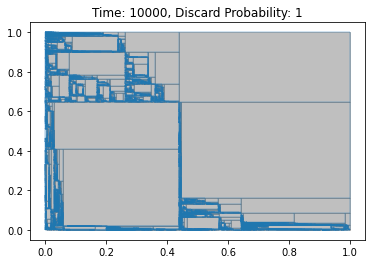

In [ ]:
# # Test the generate function
# time = 10000  # Number of steps to generate the lattice
# discard_prob = 1  # Probability of discarding the top right block
# lattice, neighbors = generate(time, discard_prob)

# # # Print the generated lattice and neighbors for verification
# # print("Lattice:")
# # print(lattice)
# # print("\nNeighbors:")
# # for i, n in enumerate(neighbors):
# #     print(f"Block {i}: {n}")

# # plt.show()  # Show the generated figure